# Particle Filtering

### Importing Required Libraries

In [5]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [6]:
# Parameters for our distribution p(observation|latent)
GAUSS_WEIGHTS = [0.3, 0.3, 0.4]
GAUSS_MEANS = [np.zeros(2), np.array([2.0,0.6]), np.array([-1.4,0.2])]
GAUSS_COVS = [np.eye(2) * 3.0, np.eye(2)*2.0, np.eye(2) * 0.1]

def observation_probability(latent: np.ndarray, observation: np.ndarray) -> float:
    """Given an observation and corresponding latent state, evaluate the likelihood.

    Args:
        latent: Latent state at current time step.
        observation: Observation at current time step.

    Returns:
        Likelihood p(observation|latent).
    """
    # Let's keep things somewhat 'simple' by making our distribution a sum of Gaussians
    likelihood = 0
    for weight, mean, cov in zip(GAUSS_WEIGHTS, GAUSS_MEANS, GAUSS_COVS):
        evaluation_mean = latent + mean
        likelihood += (
            weight * stats.multivariate_normal(mean=evaluation_mean, cov=cov).pdf(observation)
        )
    return likelihood

def observation_sample(latent: np.ndarray) -> np.ndarray:
    """Given the latent state, sample a observation.

    Args:
        latent: Latent state at current time step.

    Returns:
        Sampled observation.
    """
    # Let's keep things somewhat 'simple' by making our distribution a sum of Gaussians
    index = np.random.choice(np.arange(3), p=GAUSS_WEIGHTS)
    evaluation_mean = latent + GAUSS_MEANS[index]
    cov = GAUSS_COVS[index]
    return stats.multivariate_normal(mean=evaluation_mean, cov=cov).rvs()

def latent_sample(latent: np.ndarray) -> np.ndarray:
    """Given the latent state, sample the next latent state.

    Args:
        latent: Latent state at current time step.

    Returns:
        Sampled latent state.
    """
    # Let's keep things somewhat 'simple' by making our distribution a sum of Gaussians
    sample = np.zeros(len(latent))
    sample[0] = np.sin(latent[1]) + np.random.randn() * 0.05
    sample[1] = np.cos(latent[0]) + np.random.randn() * 0.05
    sample += 1.0 * latent
    return sample

### Part 1: Where’s the rat again?

Your friend in the biology department has been working on a fascinating experiment: tracking a rat’s movement in response to music. Initially, the rat didn’t respond to most of the songs—until they played *your favorite song*. That’s right, *your favorite song*. What are the odds? Suddenly, the rat started moving unpredictably, and the sensors struggled to keep up.

To better understand this erratic behavior, your friend developed a physically motivated model of the rat’s motion and the corresponding observations. They provide you with data and three essential distributions:

$z_t = g(z_{t-1})$  
$x_t = f(z_{t-1})$  
$p(x_t \mid z_t)$

Here, `g` and `f` are sampling functions for the latent states and observations, respectively, while $p(x_t \mid z_t)$ is the observation probability density function. Your friend has already implemented these components for you under the names `latent_sample`, `observation_sample`, and `observation_probability`.

With the observed motion data in hand, your task is to reconstruct the latent state of the rat over time using a particle filter. As your friend puts it, “It’s going to be Gaussians, isn’t it?” Oh boy, are they in for a surprise.

To complete this, you'll implement a particle filtering class that includes:

- A function to compute the weights given latent space samples.
- A function to compute the particle filtering samples for all time steps.
- A function to predict future latent states and observations.


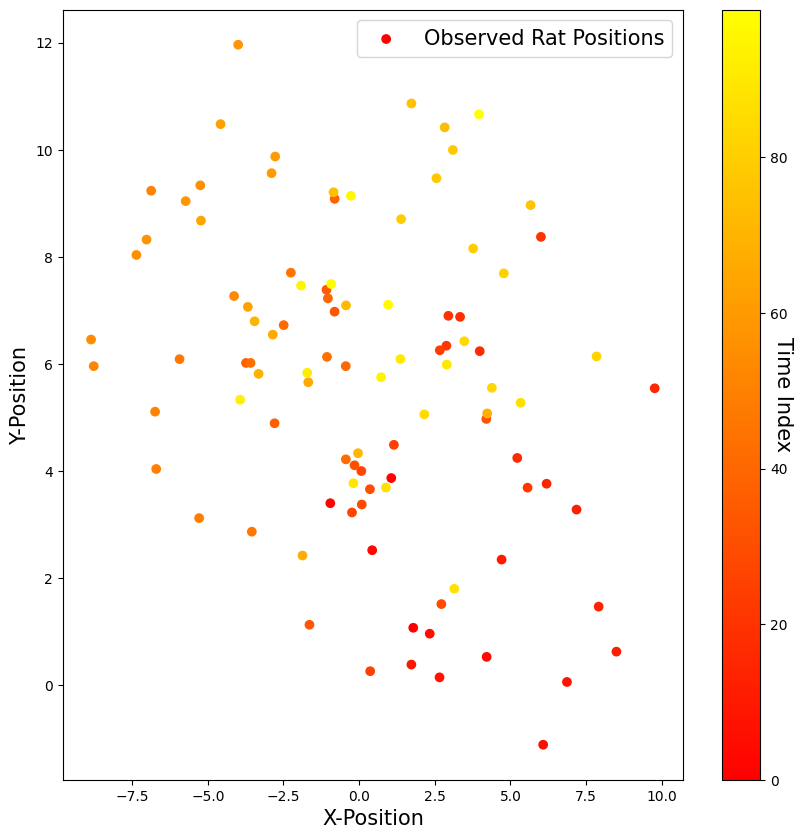

In [7]:
# Let's generate a true set of latent states and observations for our analysis.
latent_states = np.zeros((101,2))
observation_states = np.zeros((len(latent_states)-1,2))
t_observed = np.arange(len(observation_states))
np.random.seed(3)
for i in range(1, len(latent_states)):
    latent_states[i] = latent_sample(latent_states[i-1])
    observation_states[i-1] = observation_sample(latent_states[i])


# Let's visualize our data.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observation_states[:,0], observation_states[:,1], c=t_observed,
            cmap='autumn', label='Observed Rat Positions')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.show()

In [9]:
class ParticleFiltering:
    """Class that implements the Particle Filter.

    Args:
        dim_z: Dimension of latent space.
        dim_x: Dimension of observation space.
        sigma_w_zero: Initial standard deviation of the zero state.
        mu_zero: Initial mean of the zero state.
    """
    def __init__(self, dim_z: int, dim_x: int, sigma_w_zero: float,
                 mu_zero: np.ndarray):
        """Initialize our class."""
        # Save a few variables for bookkeeping
        self.dim_x = dim_x
        self.dim_z = dim_z

        # Implement the initial covariance and mean of the zero state.
        self.mu_zero = mu_zero
        self.cov_zero = sigma_w_zero ** 2 * np.eye(dim_z)

    def particle_filter(self, observations: np.ndarray, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
        """Run particle filtering algorithm to get samples for each z_t.

        Args:
            n_samples: Number of samples to draw of each state.

        Returns:
            Particle filtering samples and weights for each time step.
        """
        # Placeholder for all of our samples and weights.
        z_samples = np.zeros((len(observations) + 1, n_samples, self.dim_z))
        weights = np.zeros((len(observations) + 1, n_samples))

        # Draw initial samples and set initial weights.
        z_samples[0] = np.random.multivariate_normal(
            mean=self.mu_zero,
            cov=self.cov_zero,
            size=n_samples,
        )
        weights[0] = np.ones(n_samples) / n_samples

        # Now let's start our particle filtering loop.
        for time in range(1, len(observations) + 1):

            # Sample from the next latent state given the current latent state.
            for samp_i in range(n_samples):
                # Pick a sample with probability equal to its weight (resampling).
                sample_choice = np.random.choice(
                    np.arange(n_samples),
                    p=weights[time - 1]
                )

                # Move the selected sample and save it.
                z_samples[time, samp_i] = latent_sample(z_samples[time - 1, sample_choice])

            # Compute the weights for each of our new samples.
            weights[time] = self.compute_w(
                observations[time - 1],
                z_samples[time]
            )

        return z_samples, weights

    def compute_w(self, observation_t: np.ndarray, z_samples_t: np.ndarray) -> np.ndarray:
        """Compute the importance weights for our sample of latent states.

        Args:
            observation_t: Current observation.
            z_samples_t: Current latent state samples.

        Returns:
            Weights for each sample.
        """
        # Placeholder for the weights.
        weights_t = np.zeros(len(z_samples_t))

        # Calculate each weight.
        for i in range(len(weights_t)):
            weights_t[i] =  observation_probability(z_samples_t[i], observation_t)
        weights_t /= np.sum(weights_t)

        return weights_t

    def predict(self, final_latent_samples: np.ndarray, final_weights: np.ndarray,
                n_future: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Predict the distribution of future latent states and observations.

        Args:
            final_latent_samples: Latent samples for t=T.
            final_weights: Weights for t=T.
            n_future: Number of steps in the future to predict.

        Returns:
            Latent state samples and observations for the future.
        """
        # Placeholder for our future samples, weights, and observations.
        n_samples = len(final_latent_samples)
        z_future = np.zeros((n_future, n_samples, self.dim_z))
        obs_future = np.zeros((n_future, n_samples, self.dim_z))

        # It will be useful to keep track of the current weights
        # and samples.
        z_current = final_latent_samples
        weights_current = final_weights

        # Iterate through our time steps:
        for time_i in range(n_future):

            # Sample from the next latent state given the current latent state.
            for samp_i in range(n_samples):
                # Pick a sample with probability equal to its weight (resampling).
                sample_choice = np.random.choice(
                    np.arange(n_samples),
                    p=weights_current
                )

                # Move the selected sample and save it.
                z_future[time_i, samp_i] = latent_sample(z_current[sample_choice])

                # Generate an observation for the selected sample.
                obs_future[time_i, samp_i] = observation_sample(z_future[time_i, samp_i])

            # After the first step, the weights are uniform since there is no more
            # observations.
            weights_current = np.ones(n_samples)
            weights_current /= np.sum(weights_current)
            z_current = z_future[time_i]

        return z_future, obs_future

Let’s test our implementation:

In [10]:
pf_test = ParticleFiltering(dim_z = 2, dim_x = 2, sigma_w_zero = 0.5, mu_zero = np.array([0.2,0.4]))

# Make sure the weight calculations are correct.
test_observation = np.array([0.2, 0.4])
test_latent_states = np.array([[-0.4, 1.2], [0.3, 1.2], [-2.2, 4.2]])
np.testing.assert_array_almost_equal(
    pf_test.compute_w(test_observation, test_latent_states),
    np.array([0.53029462, 0.45243585, 0.01726953])
)

# Make sure the sampling calculations are correct.
np.random.seed(5)
test_observations = np.array([[-0.4, 1.2], [0.3, 1.2], [-2.2, 4.2]])
n_test_samples = 100
# Sadly, the remaining functions are very hard to test since they rely on the way you
# called your random functions and your version of numpy. We offer some commented tests
# that reproduce the behavior of the solutions.
z_test_samples, weights_test = pf_test.particle_filter(test_observations, n_test_samples)
# np.testing.assert_array_almost_equal(
#     np.sum(z_test_samples * weights_test[:,:,np.newaxis], axis = 1),
#     np.array([[0.193547, 0.465832],
#               [0.785028, 1.162211],
#               [1.889398, 1.370276],
#               [2.630004, 1.39772 ]])
# )
# np.testing.assert_array_almost_equal(
#     z_test_samples[:,0],
#     np.array([[0.420614, 0.234565],
#               [1.109561, 2.177135],
#               [1.403333, 2.201349],
#               [2.641904, 0.801542]])
# )
# np.testing.assert_array_almost_equal(
#     weights_test[:,0],
#     np.array([0.01, 0.001003, 0.001997, 0.00801])
# )

# Make sure the predictions are correct.
np.random.seed(5)
z_test_future, obs_test_future = pf_test.predict(
    z_test_samples[-1], weights_test[-1], n_future=2
)
# Same caveat to these tests as before.
# np.testing.assert_array_almost_equal(
#     np.mean(z_test_future, axis = 1),
#     np.array([[ 3.451687,  0.543841],
#               [ 3.889172, -0.343928]])
# )
# np.testing.assert_array_almost_equal(
#     np.mean(obs_test_future, axis = 1),
#     np.array([[3.457603, 0.905334],
#               [3.877964, 0.130703]])
# )

### Part 2: Running the Particle Filter

Run the particle filtering algorithm with sigma_w_zero = 1.1 and mu_zero = [1,1] and generate N = 100 samples

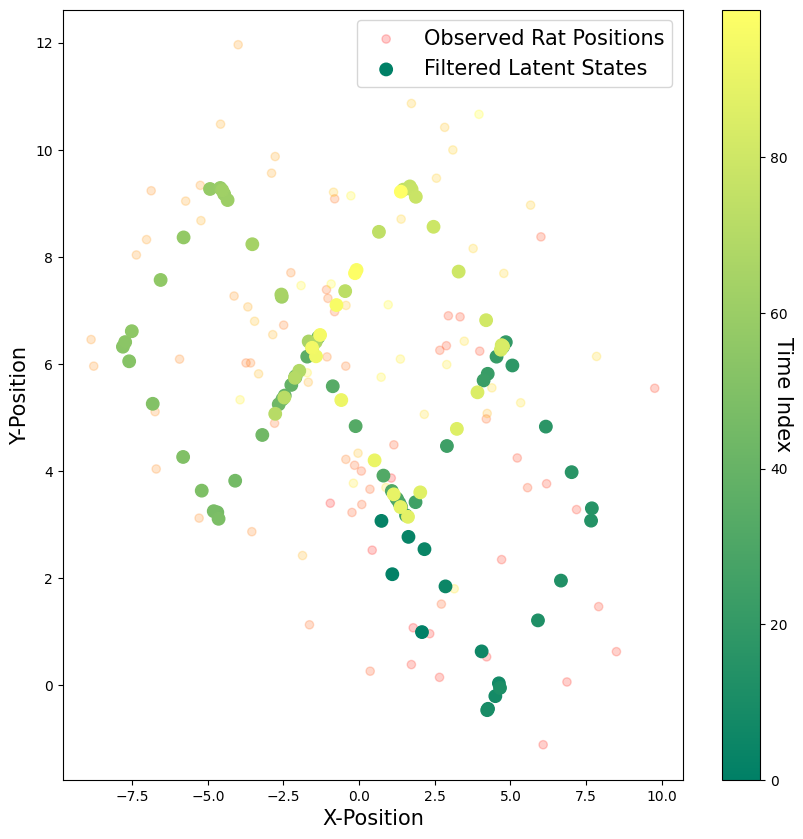

In [11]:
# Particle filter our rat position data.
np.random.seed(3)
pf_class = ParticleFiltering(
    dim_z=2,
    dim_x=2,
    sigma_w_zero=1.1,
    mu_zero=np.array([1.0, 1.0])
)
z_samples, weights = pf_class.particle_filter(
    observation_states,
    n_samples=100
)

# Get the expected value of z at each timestep.
z_mean = np.sum((z_samples * weights[:,:,np.newaxis]), axis=1)

# Let's visualize our mean fit.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observation_states[:,0], observation_states[:,1], c=t_observed,
            cmap='autumn', label='Observed Rat Positions', alpha=0.2)

plt.scatter(z_mean[1:,0], z_mean[1:,1], c=t_observed,
            cmap='summer', label='Filtered Latent States', s=80)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.show()

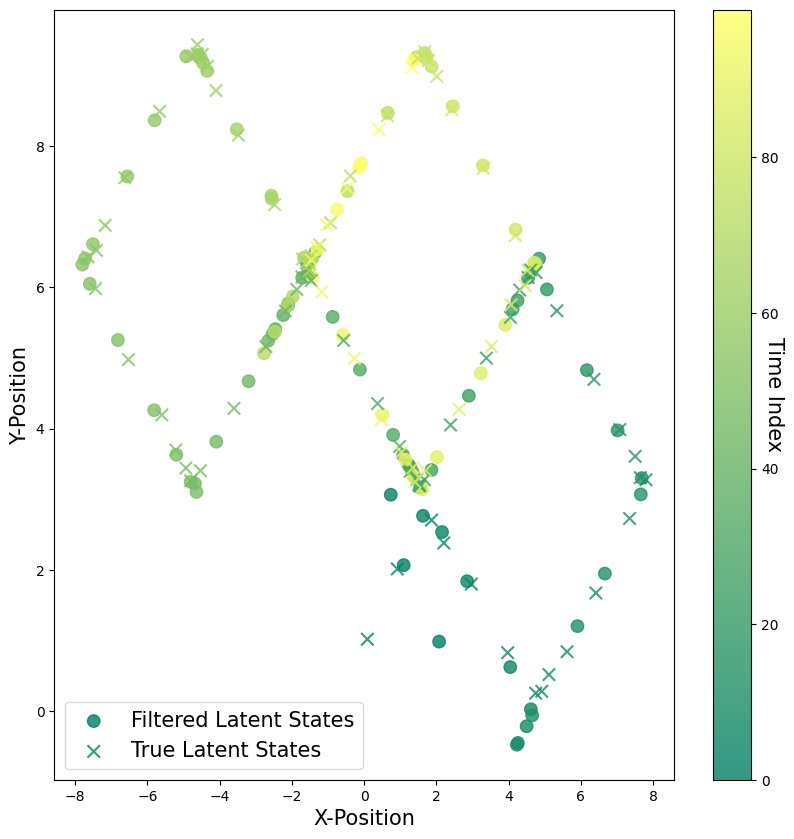

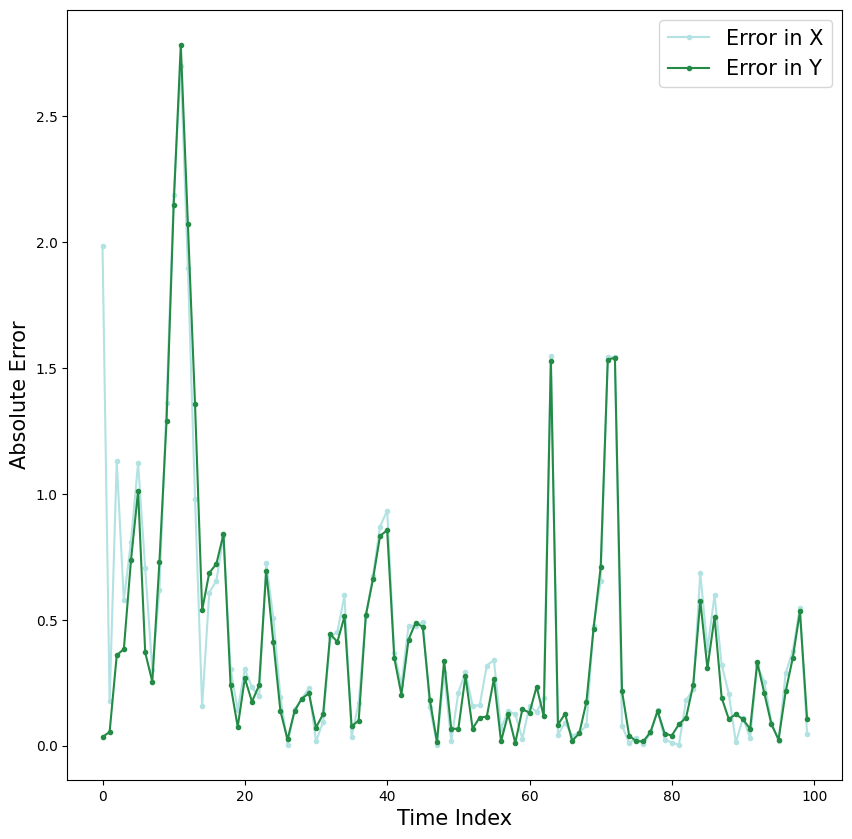

In [12]:
# Let's visualize our fit.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(z_mean[1:,0], z_mean[1:,1], c=t_observed,
            cmap='summer', label='Filtered Latent States', alpha=0.8, s=80)
plt.scatter(latent_states[1:,0], latent_states[1:,1], c=t_observed, marker='x',
            cmap='summer', label='True Latent States', alpha=0.8, s=80)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.show()

# Let's visualize our errors.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15

plt.plot(t_observed, np.abs(z_mean[1:,0] - latent_states[1:,0]), '.-', label='Error in X', c='#b2e2e2')
plt.plot(t_observed, np.abs(z_mean[1:,1] - latent_states[1:,1]), '.-', label='Error in Y', c='#238b45')
plt.xlabel('Time Index', fontsize=fontsize)
plt.ylabel('Absolute Error', fontsize=fontsize)
plt.legend(fontsize=fontsize)

**Question:** How does the error of our later latent states compare to the error of our earlier latent states? Why might this be the case?

- The later latent states have smaller and more stable errors than the early ones.                                     
                                     
- Early on, the filter is starting from a prior that may not match the true state well,                                      
and it has only seen a few observations, so many particles are in the wrong region                                     
and the posterior mean can be far from the truth. As more observations arrive, the
resample–propagate–reweight cycle gradually concentrates particles around states
that consistently explain the data, causing the posterior to become sharper and 
more accurate over time. This accumulation of information reduces uncertainty and 
drives down the average error in later time steps (with only occasional spikes due to
noise or temporary ambiguity).                                     


### Part 3: Predicting with the Particle Filter

Run the particle filtering algorithm with sigma_w_zero = 1.1 and mu_zero = [0,0] and generate N = 200 samples. Use the first 80 observations as input to your particle filtering algorithm and then predict the remaining 20 future observations and latent states.

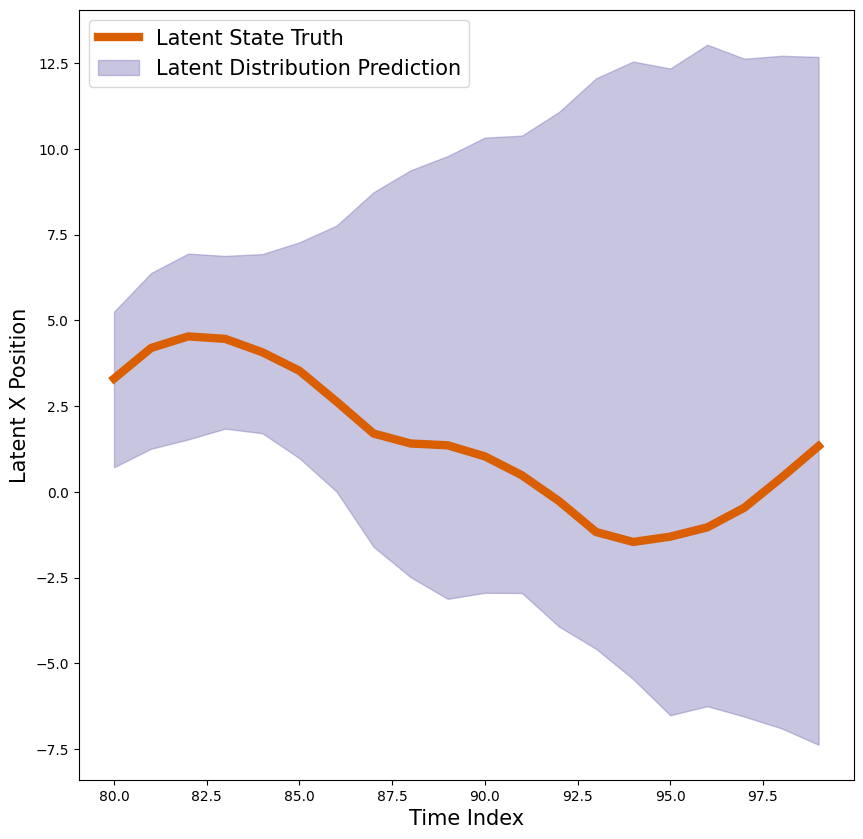

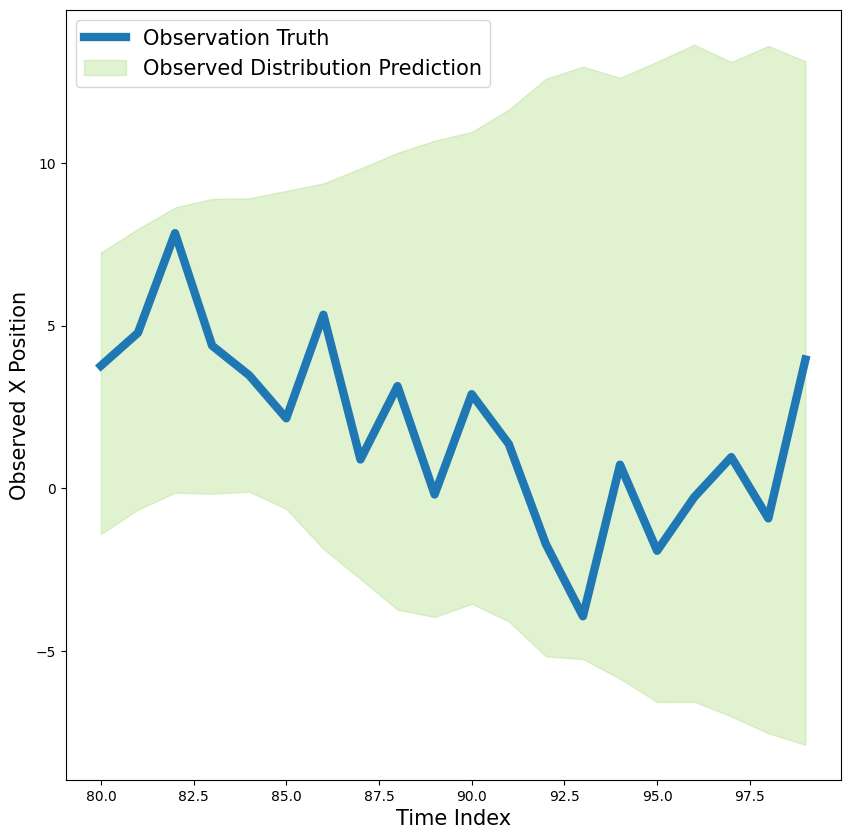

In [13]:
# Particle filter our rat position data.
np.random.seed(3)
pf_class = ParticleFiltering(
    dim_z=2,
    dim_x=2,
    sigma_w_zero=1.1,
    mu_zero=np.array([0.0, 0.0])
)

z_samples, weights = pf_class.particle_filter(
    observation_states[:80],
    n_samples=200
)

z_future, obs_future = z_future, obs_future = pf_class.predict(
    z_samples[80],
    weights[80],
    n_future=20
)

# Get the range of expected values of the latent state and observations
# at each timestep.
z_future_mean = np.mean((z_future), axis=1)
# We're visualizing our distribution as though it's Gaussian.
z_future_std = np.std((z_future), axis=1)
obs_future_mean = np.mean((obs_future), axis=1)
obs_future_std = np.std((obs_future), axis=1)

# Let's visualize if the true path falls within our range.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15

plt.plot(t_observed[80:], latent_states[81:,0], label='Latent State Truth', color='#d95f02', lw=6)
plt.fill_between(t_observed[80:], z_future_mean[:,0] - 2 * z_future_std[:,0],
                 z_future_mean[:,0] + 2 * z_future_std[:,0],
                 label='Latent Distribution Prediction', alpha=0.4, color='#7570b3')
plt.xlabel('Time Index', fontsize=fontsize)
plt.ylabel('Latent X Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15

plt.plot(t_observed[80:], observation_states[80:,0], label='Observation Truth', color='#1f78b4', lw=6)
plt.fill_between(t_observed[80:], obs_future_mean[:,0] - 2 * obs_future_std[:,0],
                 obs_future_mean[:,0] + 2 * obs_future_std[:,0],
                 label='Observed Distribution Prediction', alpha=0.4, color='#b2df8a')
plt.xlabel('Time Index', fontsize=fontsize)
plt.ylabel('Observed X Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

**Question:** How well does the particle filter predict future observations? Do the true observations fall within the predicted distribution?

- 

